In [29]:
print("test")

test


### global

In [30]:
import os
import tensorflow as tf
import torch
print(tf.__version__)
print(torch.__version__)

2.15.0
2.1.2+cpu


In [31]:
import numpy as np
print(np.__version__)
# setting random_state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

1.26.4


### some libraries and functions

In [32]:
# libraries
import sys, math
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [33]:
# fix random_state
def fixRandomState(fixed_state: int=RANDOM_STATE):
  np.random.seed(fixed_state)
  tf.random.set_seed(fixed_state)
  torch.manual_seed(fixed_state)

# exception
def exception(requirement: bool, content):
  if(requirement == False): raise ValueError(content)
def catchException(ex: Exception):
  print(type(ex), ex.args)
  exception(False, ex)

# message
def mesVerbose(flag: bool, verbose, func_dir: str=""):
  if(flag == False): return
  print("__verbose__:", func_dir, verbose)
def mesWarningToUser(note, func_dir: str=""):
  print("__warning__:", func_dir, str(note) + "&&&")

In [34]:
def over(val, name="") -> tuple:
  try: mesVerbose(True, (type(val), val.shape, str(sys.getsizeof(val)) + "Bytes"), name)
  except: mesVerbose(True, (type(val), "no-shape", str(sys.getsizeof(val)) + "Bytes"), name)

### model architecture

In [35]:
from torch import nn, optim
from torch.utils import data

BATCH_SIZE = 16
IN_SHAPE = (BATCH_SIZE, 3, 224, 224)

YOLO_BACKBONE_ARCHITECTURE = [(64, 7, 2, 'same'), 'M',
                                (192, 3, 1, 'same'), 'M',
                                (128, 1, 1, 'valid'),
                                [(128, 256), 1],
                                [(256, 512), 1], 'M',
                                [(256, 512), 4],
                                [(512, 1024), 1], 'M',
                                [(512, 1024), 2]]

GRID_SIZE = 7
NUM_BOXES = 2
NUM_CLASSES = 3
OUT_SHAPE = (BATCH_SIZE, 7, 7, 8)

In [36]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

##### nnModule

In [37]:
class nnModule(nn.Module):
  def unittest_backward(self):
    mesVerbose(True, "@@@ test backward", "nnModule > unittest_backward:")
    in_shape = self.getInShape()
    model = self.getModel()
    x = torch.rand(in_shape[0], in_shape[1], in_shape[2], in_shape[3]).to(DEVICE)
    out = self.forward(x)
    loss = nn.MSELoss()(out, torch.rand(*out.shape).to(DEVICE))

    print("example_mse_loss:", type(loss), loss)
    optimizer = optim.Adam(list(model.parameters()), lr=2e-5, weight_decay=0)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("backward finish, the weights (state) of current instance CAN changed!")
    params = list(model.parameters())
    print("parameters():", str(len(params)), str(sys.getsizeof(params))) 

  def unittest_summary(self):
    mesVerbose(True, "@@@ test summary", "nnModule > unittest_summary:")
    in_shape = self.getInShape()
    model = self.getModel()
    x = torch.rand(in_shape[0], in_shape[1], in_shape[2], in_shape[3]).to(DEVICE)
    for layer in model:
      print("\tin_shape:", type(x), x.shape)
      print(type(layer), sys.getsizeof(layer))
      x = layer(x)
    print("out_shape:", type(x), x.shape)
    
  def __init__(self) -> None:
    super(nnModule, self).__init__()
    self.in_shape = ()
    self.out_shape = ()
    self.model = nn.ModuleList()

  def getInShape(self): return self.in_shape
  def getOutShape(self): return self.out_shape
  def getModel(self): return self.model
  def setInShape(self, in_shape): self.in_shape = in_shape
  def setOutShape(self, out_shape): self.out_shape = out_shape
  def setModel(self, model): self.model = model
    
  def forward(self, x): 
    x = x.to(DEVICE) 
    for layer in self.getModel(): 
        layer = layer.to(DEVICE) 
        x = layer(x) 
    return x 


##### blcoks

In [38]:
class ConvWithBatchNorm(nnModule):
  """Conv layer with batch norm and leaky relu"""

  def __init__(self, in_c: int, out_c: int, k_size: int, stride=1, negative_slope=0.1):
    super(ConvWithBatchNorm, self).__init__()

    padding = k_size // 2
    layers = self.getModel()
    layers += [nn.Conv2d(in_c, out_c, k_size, stride=stride, padding=padding, bias=False)]
    layers += [nn.BatchNorm2d(num_features=out_c)]
    layers += [nn.LeakyReLU(negative_slope=negative_slope)]
    self.setModel(layers) 

In [39]:
class BottleNeckBlock(nnModule):
  """Block of 1x1 reduction layers followed by 3x3 conv. layer"""

  def __init__(self, in_c: int, out_ces: tuple, num_repeat: int):
    super(BottleNeckBlock, self).__init__()

    out_1x1 = out_ces[0]
    out_3x3 = out_ces[1]
    layers = self.getModel() 
    for i in range(num_repeat):
      layers += [nn.Conv2d(in_c, out_1x1, 1, stride=1, padding=0, bias=False)]
      layers += [nn.Conv2d(out_1x1, out_3x3, 3, stride=1, padding=1, bias=False)]
    self.setModel(layers) 

##### YoloBackbone

In [40]:
class YoloBackbone(nnModule):
  """YOLO backbone extract feature from the input"""

  def __init__(self, in_shpae: tuple, backbone_config=YOLO_BACKBONE_ARCHITECTURE):
    super(YoloBackbone, self).__init__()
    self.setInShape(in_shpae)
    model = self.getModel()
    x = torch.rand(in_shpae[0], in_shpae[1], in_shpae[2], in_shpae[3]).to(DEVICE)
    for i, config in enumerate(backbone_config):
      if type(config) == tuple:
        out_c, k_size, stride, _ = config
        model += [ConvWithBatchNorm(in_c=x.shape[1], out_c=out_c, k_size=k_size, stride=stride, negative_slope=0.1)]
        x = model[-1](x)

      elif type(config) == str:
        model += [nn.MaxPool2d(kernel_size=2, stride=2, padding=0)]
        x = model[-1](x)

      elif type(config) == list:
        out_ces, num_repeat = config
        model += [BottleNeckBlock(x.shape[1], out_ces, num_repeat)]
        x = model[-1](x)
    self.setOutShape(x.shape)
    self.setModel(model=model)

In [41]:
YoloBackbone((4, 3, 224, 224)).unittest_backward()

__verbose__: nnModule > unittest_backward: @@@ test backward
example_mse_loss: <class 'torch.Tensor'> tensor(0.3340, grad_fn=<MseLossBackward0>)
backward finish, the weights (state) of current instance CAN changed!
parameters(): 27 312


##### YoloOutput

In [44]:
YOLO_OUT_ARCHITECTURE = [(4096, 0.1), 0.5, (2040, 0.1), 0.5, (1024, 0.1), 0.5, (GRID_SIZE * GRID_SIZE * (NUM_BOXES * 5 + NUM_CLASSES), 0.1)]

In [45]:
class YoloOutput(nnModule):
  """YOLO last convolution and FC layers to produce prediction"""

  def __init__(self, in_shape: tuple):
    super(YoloOutput, self).__init__()
    self.setInShape(in_shape=in_shape)
    x = torch.rand(in_shape[0], in_shape[1], in_shape[2], in_shape[3]).to(DEVICE)
    model = self.getModel() 
    model += [ConvWithBatchNorm(in_shape[1], out_c=1024, k_size=3),
              ConvWithBatchNorm(1024, out_c=1024, k_size=3),
              ConvWithBatchNorm(1024, out_c=1024, k_size=3),
              ConvWithBatchNorm(1024, out_c=1024, k_size=3),
              nn.Flatten()]
    self.setModel(model) 
    x = self.forward(x) 

    for i, config in enumerate(YOLO_OUT_ARCHITECTURE):
      if type(config) == tuple:
        out_f, slop = config
        model += [nn.Linear(in_features=x.shape[1], out_features=out_f), nn.LeakyReLU(negative_slope=slop)]
        x = model[-1].to(DEVICE)(model[-2].to(DEVICE)(x))
      else:
        p = config
        model += [nn.Dropout(p=0.5)]
        x = model[-1](x)

    self.setOutShape(x.shape)
    self.setModel(model)

In [46]:
YoloOutput((16, 1024, 7, 7)).unittest_backward()

__verbose__: nnModule > unittest_backward: @@@ test backward
example_mse_loss: <class 'torch.Tensor'> tensor(0.3096, grad_fn=<MseLossBackward0>)
backward finish, the weights (state) of current instance CAN changed!
parameters(): 20 248


##### YoloV1

In [47]:
class YoloV1(nnModule):
  """End-to-end YOLO network"""

  def __init__(self, in_shape: tuple):
    super(YoloV1, self).__init__()
    self.setInShape(in_shape)

    x = torch.rand(in_shape[0], in_shape[1], in_shape[2], in_shape[3]).to(DEVICE)
    yolo_backbone = YoloBackbone(in_shape)
    x = yolo_backbone(x)
    yolo_output = YoloOutput(in_shape=x.shape)
    x = yolo_output(x)

    self.setOutShape(x.shape)
    model = self.getModel()
    model += [yolo_backbone, yolo_output]
    self.setModel(model)

In [48]:
YoloV1((16, 3, 224, 224)).to(DEVICE).unittest_backward()

__verbose__: nnModule > unittest_backward: @@@ test backward
example_mse_loss: <class 'torch.Tensor'> tensor(0.3074, grad_fn=<MseLossBackward0>)
backward finish, the weights (state) of current instance CAN changed!
parameters(): 47 472


### YoloLoss

In [49]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
  """
  Calculates intersection over union

  Parameters:
      boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
      boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
      box_format (str): midpoint/corners, if boxes are (x,y,w,h) or (x1,y1,x2,y2) respectively.

  Returns:
      tensor: Intersection over union for all examples
  """
  # boxes_preds shape is (N, 4)
  # boxes_labels shape is (N, 4)

  if box_format == 'midpoint':
      box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
      box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
      box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
      box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

      box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
      box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
      box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
      box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

  if box_format == 'corners':
      box1_x1 = boxes_preds[..., 0:1]
      box1_y1 = boxes_preds[..., 1:2]
      box1_x2 = boxes_preds[..., 2:3]
      box1_y2 = boxes_preds[..., 3:4]

      box2_x1 = boxes_labels[..., 0:1]
      box2_y1 = boxes_labels[..., 1:2]
      box2_x2 = boxes_labels[..., 2:3]
      box2_y2 = boxes_labels[..., 3:4]

  x1 = torch.max(box1_x1.to(DEVICE), box2_x1.to(DEVICE)).to(DEVICE)
  y1 = torch.max(box1_y1.to(DEVICE), box2_y1.to(DEVICE)).to(DEVICE)
  x2 = torch.min(box1_x2.to(DEVICE), box2_x2.to(DEVICE)).to(DEVICE)
  y2 = torch.min(box1_y2.to(DEVICE), box2_y2.to(DEVICE)).to(DEVICE)

  #&&& .clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
  intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1)).to(DEVICE)
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1)).to(DEVICE)
  return intersection / (box1_area + box2_area - intersection + 1e-6)


In [50]:
EPS = 1e-6
def sign_sqrt(pred):
  return torch.sign(pred) * torch.sqrt(torch.abs(pred + EPS))
#&&& tai 0 khong co dao ham cua abs

In [51]:
class YoloLoss(nn.Module):
  def __init__(self, coord_c=5, noobj_c=0.5):
    super(YoloLoss, self).__init__()
    self.COORD = coord_c
    self.NOOBJ = noobj_c
    self.mse = nn.MSELoss(reduction="sum")

  def setLoss(self, some_loss): self.some_loss = some_loss
  def getLoss(self): return self.some_loss

  def forward(self, predictions: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    predictions, target = predictions.to(DEVICE), target.to(DEVICE)
    predictions = predictions.reshape((-1, GRID_SIZE, GRID_SIZE, NUM_BOXES * 5 + NUM_CLASSES))
    exists_box = target[..., [4]]
    iou_b1 = intersection_over_union(
        predictions[...,0:4], target[..., 0:4])
    iou_b2 = intersection_over_union(
        predictions[..., 5:9], target[..., 0:4])
    bestbox = torch.where(iou_b1 >= iou_b2, 0, 1)

    # class loss
    class_loss = self.mse(
      exists_box * predictions[..., 10:],
      exists_box * target[..., 5:])

    # obj loss
    pred_box = (
        (1-bestbox) * predictions[..., [4]] + (bestbox) * predictions[..., [9]]
    )
    object_loss = self.mse(
      exists_box * pred_box,
      exists_box * target[..., [4]]
    )

    # coor loss
    pred_box = (
        (1-bestbox) * predictions[..., 0:4] + (bestbox) * predictions[..., 5:9]
    )
    true_box = target[..., 0:4]
    pred_box[..., 2:4] = sign_sqrt(pred_box[..., 2:4])
    true_box[..., 2:4] = sign_sqrt(true_box[..., 2:4])
    coor_loss = self.mse(
      #exists_box * pred_box, end_dim=-2),
      #exists_box * true_box, end_dim=-2),
      exists_box * pred_box, exists_box * true_box
    )

    # no obj loss
    no_obj_loss = self.mse(
      (1 - exists_box) * predictions[..., [4]], (1 - exists_box) * target[..., [4]]
    )
    no_obj_loss += self.mse(
      (1 - exists_box) * predictions[..., [9]], (1 - exists_box) * target[..., [4]]
    )
    self.setLoss((class_loss, coor_loss, object_loss, no_obj_loss))
    return class_loss + object_loss + self.COORD * coor_loss + self.NOOBJ * no_obj_loss

  def unittest_loss_backloss(self):
    mesVerbose(True, "@@@ test loss and backloss", "YoloLoss > unittest_loss_backloss:")
    model = YoloV1(in_shape=IN_SHAPE)
    x = torch.rand(*IN_SHAPE)
    out = model(x)
    y = torch.rand(*OUT_SHAPE)
    loss = self.forward(out, y)

    print("example_loss:", type(loss), loss)
    optimizer = optim.Adam(list(model.parameters()), lr=2e-5, weight_decay=0)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("loss and backloss finish")


In [ ]:
YoloLoss().unittest_loss_backloss()

### DataLoad

In [21]:
import os
from xml.etree import ElementTree
import tensorflow as tf
from tqdm import tqdm
from functools import partial
from keras.preprocessing.image import load_img, img_to_array
from torch.utils import data
import pandas as pd 
import numpy as np 

class_names = ['apple', 'banana', 'orange']

class DataLoad(data.Dataset):
  def utest_loaddata(self):
    mesVerbose(True, "@@@ test load data", "DataLoad(nn.Dataset) > utest_loaddata:")
    print("repeat:", self.repeat)
    print("is aug:", self.aug)
    over(self.imgs, "imgs = ")
    over(self.labels, "labels = ")

  def utest_getdata(self):
    mesVerbose(True, "@@@ test get data", "DataLoad(nn.Dataset) > utest_getdata:")
    x, y = self.__getitem__(0)
    over(x, "x = ")
    over(y, "y = ")

  def __init__(self, file_dir, repeat, aug=False) -> None:
    super().__init__()
    self.repeat, self.aug = repeat, aug
    dataframe = self.get_dataframe(file_dir=file_dir)
    self.imgs, self.labels = self.load_dataset(dataframe, input_shape=(224, 224, 3), #!!!
                                                grid_size=GRID_SIZE) # np.ndarray
    # repeat
    for i in range(repeat):
      self.imgs = np.concatenate((self.imgs, self.imgs), axis=0)
      self.labels = np.concatenate((self.labels, self.labels), axis=0)
    # aug
    if(aug == True):
      for i, img in enumerate(self.imgs):
        label = self.labels[i]
        self.imgs[i], self.labels[i] = self._apply_augmentation(img, label, seed=RANDOM_STATE)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
      x, y = self.imgs[idx], self.labels[idx] # np.ndarray
      x, y = tf.convert_to_tensor(x), tf.convert_to_tensor(y) # tf.tensor
      x = torch.tensor(x.numpy(), dtype=torch.float32)  # torch.tensor
      y = torch.tensor(y.numpy(), dtype=torch.float32)
      return x, y


  def get_dataframe(self, file_dir):
    """
    Get the train/val/test dataframe which contains image
    file names and annotations files. If `phase = train',
    return train and val set
    :param file_dir: File directory to create dataframe
    :return file_df: Train or test dataframe
    """

    img_files = [os.path.join(file_dir, img_file) for img_file
                 in sorted(os.listdir(file_dir)) if img_file[-4:] == '.jpg']
    annot_files = [img_file[:-4] + '.xml' for img_file in img_files]

    img_file_series = pd.Series(img_files, name='Image_file')
    annot_file_series = pd.Series(annot_files, name='Annotation_file')
    file_df = pd.DataFrame(pd.concat([img_file_series, annot_file_series], axis=1))
    return file_df

  def prepare_image(self, filename, input_shape):
    """
    Resize image to expected dimension, and opt. apply some random transformation.
    :param filename: File name
    :param input_shape: Shape expected by the model (image will be resize accordingly)
    :return : 3D image array, pixel values from [0., 1.]
    """

    img = img_to_array(load_img(filename, target_size=input_shape)) / 255.
    img = np.einsum('ijk->kij', img)
    return img

  def convert_to_xywh(self, bboxes):
    """
    Convert list of (xmin, ymin, xmax, ymax) to
    (x_center, y_center, box_width, box_height)
    :param bboxes: List of bounding boxes, each has 4
    values (xmin, ymin, xmax, ymax)
    :return boxes: List of bounding boxes, each has 4
    values (x_center, y_center, box_width, box_height)
    """

    boxes = list()
    for box in bboxes:
        xmin, ymin, xmax, ymax = box

        # Compute width and height of box
        box_width = xmax - xmin
        box_height = ymax - ymin

        # Compute x, y center
        x_center = int(xmin + (box_width / 2))
        y_center = int(ymin + (box_height / 2))

        boxes.append((x_center, y_center, box_width, box_height))

    return boxes

  def extract_annotation_file(self, filename):
    """
    Extract bounding boxes from an annotation file
    :param filename: Annotation file name
    :return boxes: List of bounding boxes in image, each box has
    4 values (x_center, y_center, box_width, box_height)
    :return classes: List of classes in image
    :return width: Width of image
    :return height: Height of image
    """

    # Load and parse the file
    tree = ElementTree.parse(filename)
    # Get the root of the document
    root = tree.getroot()
    boxes = list()
    classes = list()

    # Extract each bounding box
    for box in root.findall('.//object'):
        cls = class_names.index(box.find('name').text)
        xmin = int(box.find('bndbox/xmin').text)
        ymin = int(box.find('bndbox/ymin').text)
        xmax = int(box.find('bndbox/xmax').text)
        ymax = int(box.find('bndbox/ymax').text)
        coors = (xmin, ymin, xmax, ymax)
        boxes.append(coors)
        classes.append(cls)

    boxes = self.convert_to_xywh(boxes)

    # Get width and height of an image
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)

    # Some annotation files have set width and height by 0,
    # so we need to load image and get it width and height
    if (width == 0) or (height == 0):
        img = load_img(filename[:-4] + '.jpg')
        width, height = img.width, img.height

    return boxes, classes, width, height

  def convert_bboxes_to_tensor(self, bboxes, classes, img_width, img_height, grid_size=7):
    """
    Convert list of bounding boxes to tensor target
    :param bboxes: List of bounding boxes in image, each box has
    4 values (x_center, y_center, box_width, box_height)
    :param classes: List of class in image
    :param img_width: Image's width
    :param img_height: Image's height
    :param grid_size: Grid size
    :return target: Target tensor (grid_size x grid_size x (5 + num_classes))
    """

    num_classes = len(class_names)
    target = np.zeros(shape=(grid_size, grid_size, 5 + num_classes), dtype=np.float32)

    for idx, bbox in enumerate(bboxes):
        x_center, y_center, width, height = bbox

        # Compute size of each cell in grid
        cell_w, cell_h = img_width / grid_size, img_height / grid_size

        # Determine cell i, j of bounding box
        i, j = int(y_center / cell_h), int(x_center / cell_w)

        # Compute value of x_center and y_center in cell
        x, y = (x_center / cell_w) - j, (y_center / cell_h) - i

        # Normalize width and height of bounding box
        w_norm, h_norm = width / img_width, height / img_height

        # Add bounding box to tensor
        # Set x, y, w, h
        target[i, j, :4] += (x, y, w_norm, h_norm)
        # Set obj score
        target[i, j, 4] = 1.
        # Set class dist.
        target[i, j, 5 + classes[idx]] = 1.
    return target

  def load_dataset(self, dataframe, input_shape, grid_size=7):
    """
    Load img and target tensor
    :param dataframe: Dataframe contains img files and annotation files
    :param input_shape: Shape expected by the model (image will be resize accordingly)
    :param grid_size: Grid size
    :return dataset: Iterable dataset
    """

    imgs, targets = list(), list()

    for _, row in tqdm(dataframe.iterrows()):
        img = self.prepare_image(row.Image_file, input_shape)
        target = self.extract_annotation_file(row.Annotation_file)
        target = self.convert_bboxes_to_tensor(*target, grid_size)
        imgs.append(img)
        targets.append(target)

    imgs = np.array(imgs)
    targets = np.array(targets)
    return imgs, targets
    # dataset = tf.data.Dataset.from_tensor_slices((imgs, targets))
    # return dataset

  def _apply_augmentation(self, image, target, seed=None):
    """
    Apply random brightness and saturation on image
    :param image: Image to augment
    :param target: Target tensor
    :param seed: Seed for random operation
    :return : Processed data
    """

    # Random bright & saturation change
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)

    # Keeping pixel values in check
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    return image, target

  def load_dataset_from_df(self, dataframe, batch_size=32, num_repeat=None, shuffle=False,
                         input_shape=(448, 448, 3), grid_size=7, augment=False,
                         seed=None):
    """
    Instantiate dataset
    :param dataframe: Dataframe contains img files and annotation files
    :param batch_size: Batch size
    :param num_epochs: Number of epochs (to repeat the iteration - infinite if None)
    :param shuffle: Flag to shuffle the dataset (if True)
    :param input_shape: Shape of the processed image
    :param grid_size: Grid size
    :param augment: Flag to apply some random augmentations to the image
    :param seed: Random seed for operation
    :return : Iterable dataset
    """

    apply_augmentation = partial(self._apply_augmentation, seed=seed)
    dataset = self.load_dataset(dataframe, input_shape, grid_size)
    ### !!!
    dataset = dataset.repeat(num_repeat)
    if shuffle:
        dataset = dataset.shuffle(1000, seed)
    if augment:
        dataset = dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# train_dir = '/content/drive/MyDrive/Colab Notebooks/My_Laptop_Data/fruits_dataset/train'
train_dir = '/kaggle/input/dataset1/fruits_dataset/train'
dataload = DataLoad(train_dir, aug=False, repeat=4)
train_df = dataload.get_dataframe(train_dir)

In [ ]:
dataload.utest_loaddata()
dataload.utest_getdata()

In [ ]:
# Assuming train_dataset is your training dataset
# train_loader = DataLoader(dataset=dataload, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, prefetch_factor=2)


In [ ]:
# Assuming train_dataset is your training dataset
train_loader = data.DataLoader(dataset=dataload, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

In [ ]:
over(train_loader, "train_loader=")

### training and testing

In [ ]:
def train_fn(train_loader, model, optimizer, loss_fn):
  mesVerbose(True, "@@@ --- training ---", "train_fn:")
  print("Data was loaded")
  loop = tqdm(train_loader, leave=True)
  sum_loss = 0 
  
  for batch_idx, (x, y) in enumerate(loop):
#     mesVerbose(True, "@@@ --- training loop ---", "train_fn > loop:")
    x, y = x.to(DEVICE), y.to(DEVICE)
    out = model(x)
    loss = loss_fn(out, y)

#     print("some_loss = ", loss_fn.getLoss())
#     print("loss = ", loss) 
    sum_loss = loss + sum_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("State of model was CHANGE!")
  print(f"Mean loss of epoch was {sum_loss / (len(loop))}")
  return sum_loss / len(loop) 

In [ ]:
# train_loader = data.DataLoader(dataset=dataload, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
model = YoloV1(in_shape=IN_SHAPE).to(DEVICE)
optimizer = optim.Adam(list(model.parameters()), lr=2e-5, weight_decay=0)
loss_fn = YoloLoss().to(DEVICE)

In [ ]:
train_fn(train_loader, model, optimizer, loss_fn)

In [ ]:
loss_in_epochs = [] 
for epoch in range(0): 
  loss_in_epochs.append(train_fn(train_loader, model, optimizer, loss_fn))

In [ ]:
torch.save(model.state_dict(), 'model1.pth')

# DEPLOY STAGE

In [3]:
import torch 
GRID_SIZE = 7 
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

In [148]:
import torchvision 
import matplotlib.patches as patches

class PostProcessing: 
    def utest_post_processing(self): 
        mesVerbose(True, "@@@ test post processing", "PostProcessing > utest_post_processing:")
        out = torch.rand(1, 7 * 7 * 13)
        print(self.post_processing_one_output(out)) 
        print("test finish")
    
    def setModel(self, model): self.model = model
    def getModel(self): return self.model
    def setWHImg(self, w, h): self.img_w, self.img_h = w, h
    def getWHImg(self): return self.img_w, self.img_h
    def setCeil(self, w, h): self.ceil_w, self.ceil_h = w, h 
    def getCeil(self): return self.ceil_w, self.ceil_h 
    def setXY(self, x, y): self.x, self.y = x, y
    def getXY(self): return self.x, self.y 
    def setDataLoad(self, dl): self.dataload = dl 
    def getDataLoad(self): return self.dataload
    def createModel(self):
        builtin_model = YoloV1(in_shape=IN_SHAPE)
        builtin_model.load_state_dict(
            torch.load('/kaggle/working/model1.pth', 
           map_location=torch.device('cpu'))) 
        builtin_model.eval() 
        self.setModel(builtin_model)
    def createDataLoad(self): 
        train_dir = '/kaggle/input/dataset1/fruits_dataset/train'
        dataload = DataLoad(train_dir, aug=False, repeat=0)
        self.setDataLoad(dataload)
    def __init__(self, img_w, img_h):
        self.setWHImg(img_w, img_h) 
        S = GRID_SIZE
        ceil_w, ceil_h = img_w / S, img_h / S 
        self.setCeil(ceil_w, ceil_h)
        x0 = torch.rand(S, S, 1).to(DEVICE)
        y0 = torch.rand(S, S, 1).to(DEVICE)
        for i in range(S): 
            for j in range(S): 
                x0[i, j, 0], y0[i, j, 0] = i * ceil_w, j * ceil_h
        self.setXY(x0, y0)
        self.createModel() 
        self.createDataLoad() 
    
    def change_const(self, conf, iou): 
        self.conf, self.iou = conf, iou 
    def post_processing_one_output(self, out: torch.Tensor):
        out.to(DEVICE)
        out = out.reshape(-1, GRID_SIZE, GRID_SIZE, NUM_BOXES * 5 + NUM_CLASSES)
        # conver x, y 
        coor1 = out[..., 0:4]
        coor2 = out[..., 5:9]
        ceil_w, ceil_h = self.getCeil() 
        ceil_x, ceil_y = self.getXY() 
        coor1[..., [0]] = coor1[..., [0]] * ceil_w + ceil_x
        coor1[..., [1]] = coor1[..., [1]] * ceil_h + ceil_y
        coor2[..., [0]] = coor2[..., [0]] * ceil_w + ceil_x
        coor2[..., [1]] = coor2[..., [1]] * ceil_h + ceil_y
        # convert w, h 
        img_w, img_h = self.getWHImg() 
        coor1[..., [2]] = coor1[..., [2]] * img_w
        coor1[..., [3]] = coor1[..., [3]] * img_h 
        coor2[..., [2]] = coor2[..., [2]] * img_w 
        coor2[..., [3]] = coor2[..., [3]] * img_h 
        # convert xyxy
        x, y, w, h = coor1[..., [0]], coor1[..., [1]], coor1[..., [2]], coor1[..., [3]]
        coor1[..., [0]], coor1[..., [1]], coor1[..., [2]], coor1[..., [3]] = x-w/2, y-w/2, x+w/2, y+w/2
        x, y, w, h = coor2[..., [0]], coor2[..., [1]], coor2[..., [2]], coor2[..., [3]]
        coor2[..., [0]], coor2[..., [1]], coor2[..., [2]], coor2[..., [3]] = x-w/2, y-w/2, x+w/2, y+w/2
            
        # cat coor
        coor1, coor2 = torch.flatten(coor1, end_dim=-2), torch.flatten(coor2, end_dim=-2)
        coors = torch.cat((coor1, coor2), dim=0)
        # convert score
        score1, _ = torch.max(out[..., [4]] * out[..., 10:13], dim=-1, keepdim=True)
        score2, _ = torch.max(out[..., [9]] * out[..., 10:13], dim=-1, keepdim=True)
        score1, score2 = torch.flatten(score1), torch.flatten(score2)
        scores = torch.cat((score1, score2), dim=0)
        
        selected = [i for i in range((scores.shape[0])) if(scores[i] > self.conf)]
        coors, scores = coors[selected], scores[selected]
        selected_indices = torchvision.ops.nms(coors, scores, self.iou)
        print("num_select_rect", len(selected_indices), "/", len(coors))
        return coors[selected_indices], scores[selected_indices]
    
    def deploy(self, idx): 
        dataload = self.getDataLoad() 
        img, _ = dataload[[idx]] 
        over(img, "img = ")
        img3d = img.reshape(3, 224, 224)
        image_array = img3d.permute(1, 2, 0).cpu().numpy()  # Assuming image_tensor is on CPU
        
        fig, ax = plt.subplots() 
        ax.imshow(image_array)
    
        model = self.getModel() 
        out = model.forward(img) 
        over(out, "out = ") 
        coors, scores = self.post_processing_one_output(out)
        print(coors, scores)
        
        for bbox in coors: 
            rect = patches.Rectangle((bbox[0].item(), bbox[1].item()), 
                     bbox[2].item()-bbox[0].item(), bbox[3].item()-bbox[1].item(), 
                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()

In [149]:
demo = PostProcessing(224, 224)

240it [00:03, 67.14it/s] 


__verbose__: img =  (<class 'torch.Tensor'>, torch.Size([1, 3, 224, 224]), '80Bytes')
__verbose__: out =  (<class 'torch.Tensor'>, torch.Size([1, 637]), '80Bytes')
num_select_rect 5 / 5
tensor([[ 41.7339,  84.1179, 113.8946, 156.2786],
        [104.0222,  38.6167, 171.0479, 105.6424],
        [107.1962,  98.4764, 176.3652, 167.6454],
        [ 96.4925,  32.7714, 177.5366, 113.8155],
        [ 80.6621,  48.1615, 146.3367, 113.8360]], grad_fn=<IndexBackward0>) tensor([0.4721, 0.3880, 0.3404, 0.3260, 0.2603], grad_fn=<IndexBackward0>)


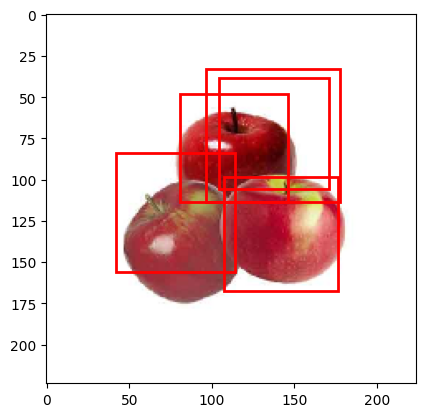

In [165]:
demo.change_const(0.25, 0.9)
demo.deploy(64) 

In [57]:
print(1)

1


### End